In [1]:
import pandas as pd
from scipy.stats import median_abs_deviation
import ast
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
df = pd.read_csv('../Data/voitures_preprocessed_v3.csv', encoding='latin')
df.columns

Index(['Prix', 'Kilométrage', 'Nombre_de_portes', 'Première_main',
       'Puissance_fiscale', 'Carburant_Diesel', 'Carburant_Electrique',
       'Carburant_Essence', 'Carburant_Hybride', 'Carburant_LPG',
       'BoiteàV_Automatique', 'BoiteàV_Manuelle', 'Origine_Dédouanée',
       'Origine_Importée_neuve', 'Origine_Pas_encore_dédouanée',
       'Origine_WW_au_Maroc', 'Marque_Modele_Encoded', 'Age'],
      dtype='object')

In [3]:
df.rename(columns={
    'Kilométrage': 'Kilometrage',
    'Première_main': 'Premiere_main',
    'BoiteàV_Automatique': 'BoiteaV_Automatique',
    'BoiteàV_Manuelle': 'BoiteaV_Manuelle',
    'Origine_Dédouanée': 'Origine_Dedouanee',
    'Origine_Importée_neuve': 'Origine_Importee_neuve',
    'Origine_Pas_encore_dédouanée': 'Origine_Pas_encore_dedouanee',
    'Origine_WW_au_Maroc': 'Origine_WW_au_Maroc'
}, inplace=True)


In [4]:
df

,Prix,Kilometrage,Nombre_de_portes,Premiere_main,Puissance_fiscale,Carburant_Diesel,Carburant_Electrique,Carburant_Essence,Carburant_Hybride,Carburant_LPG,BoiteaV_Automatique,BoiteaV_Manuelle,Origine_Dedouanee,Origine_Importee_neuve,Origine_Pas_encore_dedouanee,Origine_WW_au_Maroc,Marque_Modele_Encoded,Age
0,11.849405,124999.5,5.0,0.0,0.729458,1,0,0,0,0,0,1,0,0,0,1,1.182158e+05,1.945910
1,13.253393,134999.5,5.0,1.0,0.782509,1,0,0,0,0,1,0,0,0,0,1,3.880283e+05,1.791759
2,12.498746,7499.5,5.0,0.0,0.729458,1,0,0,0,0,1,0,0,0,0,1,1.241927e+05,0.693147
3,11.728045,224999.5,5.0,1.0,0.782509,1,0,0,0,0,1,0,0,0,0,1,2.933840e+06,2.639057
4,12.899222,144999.5,5.0,0.0,0.782509,1,0,0,0,0,1,0,0,1,0,0,4.295238e+05,2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31109,11.373675,184999.5,5.0,1.0,0.729458,1,0,0,0,0,0,1,0,0,0,1,9.841739e+04,2.079442
31110,12.180760,82499.5,5.0,1.0,0.756952,1,0,0,0,0,0,1,1,0,0,0,3.170961e+05,2.484907
31111,10.308986,224999.5,5.0,1.0,0.729458,1,0,0,0,0,0,1,0,0,1,0,6.619796e+04,3.218876
31112,11.995358,104999.5,5.0,1.0,0.729458,1,0,0,0,0,1,0,0,0,0,1,1.341063e+05,1.609438


In [5]:
X = df.drop(columns=['Prix'], axis=1)
y = df['Prix']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=42)


In [6]:
X.columns

Index(['Kilometrage', 'Nombre_de_portes', 'Premiere_main', 'Puissance_fiscale',
       'Carburant_Diesel', 'Carburant_Electrique', 'Carburant_Essence',
       'Carburant_Hybride', 'Carburant_LPG', 'BoiteaV_Automatique',
       'BoiteaV_Manuelle', 'Origine_Dedouanee', 'Origine_Importee_neuve',
       'Origine_Pas_encore_dedouanee', 'Origine_WW_au_Maroc',
       'Marque_Modele_Encoded', 'Age'],
      dtype='object')

In [7]:
from sklearn.metrics import mean_absolute_percentage_error


def eval_model(y_true, y_pred, name="Modèle"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f"🔹 {name}")
    print(f"   ➤ MAE   : {mae:.2f}")
    print(f"   ➤ MSE   : {mse:.2f}")
    print(f"   ➤ RMSE  : {rmse:.2f}")
    print(f"   ➤ R²    : {r2:.4f}")
    print(f"   ➤ MAPE  : {mape:.2f}%")
    print()

In [8]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.3),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

In [9]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017C612FF4D0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017C61305F10>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017C61306550>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017C61304D10>},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [10]:
best_params = random_search.best_params_

final_model = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    eval_metric= "rmse",
)

final_model.fit(
    X_train,  
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)


[0]	validation_0-rmse:0.74075
[1]	validation_0-rmse:0.73099
[2]	validation_0-rmse:0.72096
[3]	validation_0-rmse:0.71465
[4]	validation_0-rmse:0.70762
[5]	validation_0-rmse:0.70346
[6]	validation_0-rmse:0.69445
[7]	validation_0-rmse:0.68555
[8]	validation_0-rmse:0.67719
[9]	validation_0-rmse:0.66903
[10]	validation_0-rmse:0.66101
[11]	validation_0-rmse:0.65316
[12]	validation_0-rmse:0.64556
[13]	validation_0-rmse:0.63954
[14]	validation_0-rmse:0.63567
[15]	validation_0-rmse:0.62858
[16]	validation_0-rmse:0.62300
[17]	validation_0-rmse:0.61508
[18]	validation_0-rmse:0.60814
[19]	validation_0-rmse:0.60364
[20]	validation_0-rmse:0.59639
[21]	validation_0-rmse:0.58834
[22]	validation_0-rmse:0.58214
[23]	validation_0-rmse:0.57499
[24]	validation_0-rmse:0.56902
[25]	validation_0-rmse:0.56544
[26]	validation_0-rmse:0.55822
[27]	validation_0-rmse:0.55111
[28]	validation_0-rmse:0.54509
[29]	validation_0-rmse:0.54094
[30]	validation_0-rmse:0.53707
[31]	validation_0-rmse:0.53337
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5563186594297085, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=0.02460568344736499, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.019578473763021277,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=980, n_jobs=None,
             num_parallel_tree=None, ...)

In [11]:
y_pred_xgb = final_model.predict(X_test)

eval_model(y_test, y_pred_xgb, "XGBoost")


🔹 XGBoost
   ➤ MAE   : 0.15
   ➤ MSE   : 0.09
   ➤ RMSE  : 0.30
   ➤ R²    : 0.8345
   ➤ MAPE  : 1.33%



In [12]:
import joblib as jb

jb.dump(final_model, "price_predictor.pkl")

['price_predictor.pkl']

In [13]:
from sklearn.model_selection import KFold

scoring = {
    'r2': 'r2',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error'
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(final_model, X, y, scoring=scoring, cv=cv, return_train_score=True)

print("R² moyenne : {:.4f} (+/- {:.4f})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
print("RMSE moyenne : {:.4f}".format(-scores['test_neg_root_mean_squared_error'].mean()))
print("MAE moyenne : {:.4f}".format(-scores['test_neg_mean_absolute_error'].mean()))

R² moyenne : 0.8237 (+/- 0.0197)
RMSE moyenne : 0.3171
MAE moyenne : 0.1571


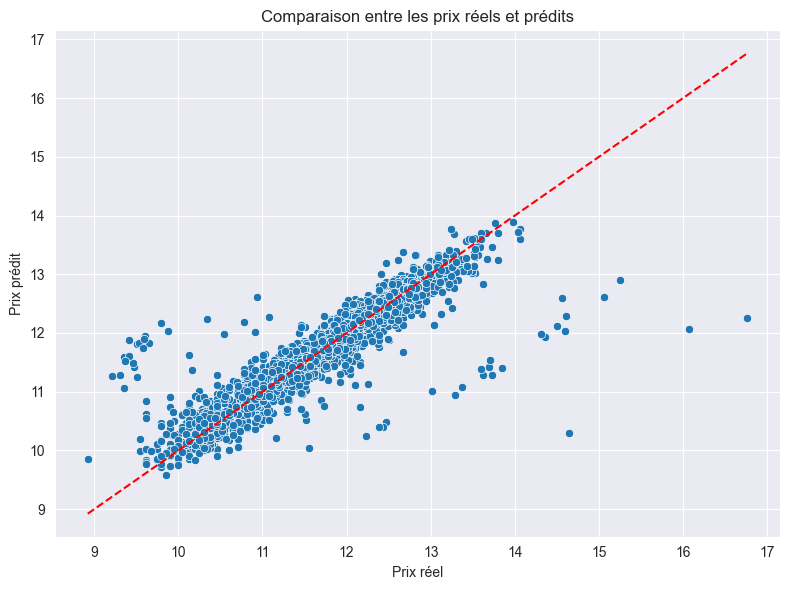

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonale parfaite
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Comparaison entre les prix réels et prédits")
plt.grid(True)
plt.tight_layout()
plt.show()


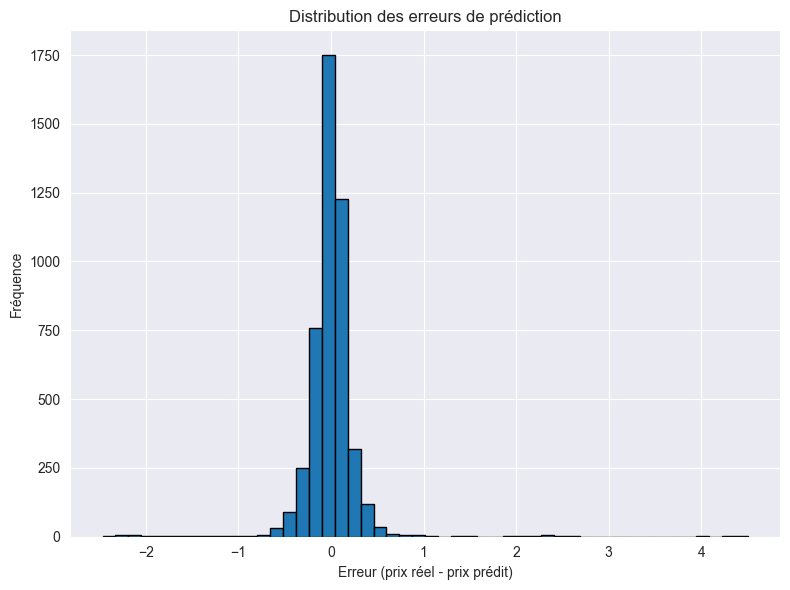

In [15]:
import matplotlib.pyplot as plt

errors = y_test - y_pred_xgb

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, edgecolor='k')
plt.xlabel("Erreur (prix réel - prix prédit)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.grid(True)
plt.tight_layout()
plt.show()


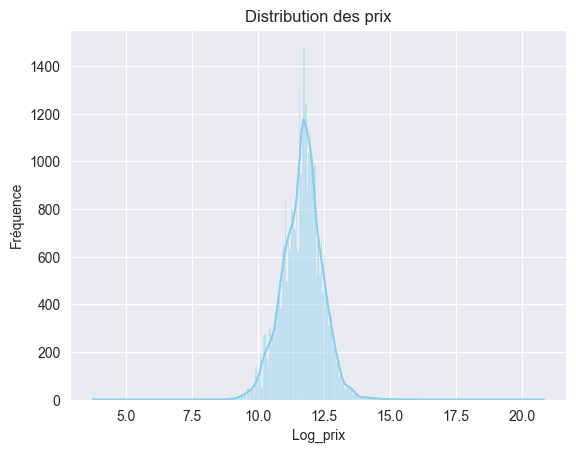

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Prix'], kde= True, color='skyblue')
plt.title("Distribution des prix")
plt.xlabel("Log_prix")
plt.ylabel("Fréquence")
plt.show()

In [17]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()

# Définir la grille de paramètres
param_dist_catboost = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(3, 10),
    'min_data_in_leaf': randint(1, 10),
    'subsample': uniform(0.5, 1.0),
    'colsample_bylevel': uniform(0.5, 1.0),
    'l2_leaf_reg': uniform(0, 1),
    'border_count': randint(32, 255)
}

# Effectuer une recherche aléatoire des meilleurs paramètres
random_search1 = RandomizedSearchCV(model, param_distributions=param_dist_catboost, 
                                   n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Entraîner le modèle sur les données
random_search1.fit(X_train, y_train)

# Meilleur modèle et ses paramètres
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\yahya\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
185 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yahya\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python311\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

0:	learn: 0.6934558	total: 123ms	remaining: 46.2s
1:	learn: 0.6375992	total: 128ms	remaining: 23.9s
2:	learn: 0.5893121	total: 132ms	remaining: 16.4s
3:	learn: 0.5486158	total: 136ms	remaining: 12.6s
4:	learn: 0.5136142	total: 140ms	remaining: 10.4s
5:	learn: 0.4840782	total: 145ms	remaining: 8.96s
6:	learn: 0.4608199	total: 151ms	remaining: 7.98s
7:	learn: 0.4421207	total: 157ms	remaining: 7.23s
8:	learn: 0.4270479	total: 162ms	remaining: 6.6s
9:	learn: 0.4136674	total: 167ms	remaining: 6.1s
10:	learn: 0.4035473	total: 171ms	remaining: 5.69s
11:	learn: 0.3946410	total: 176ms	remaining: 5.35s
12:	learn: 0.3869237	total: 181ms	remaining: 5.05s
13:	learn: 0.3811013	total: 186ms	remaining: 4.8s
14:	learn: 0.3761183	total: 192ms	remaining: 4.62s
15:	learn: 0.3718044	total: 197ms	remaining: 4.43s
16:	learn: 0.3682104	total: 202ms	remaining: 4.27s
17:	learn: 0.3651843	total: 208ms	remaining: 4.15s
18:	learn: 0.3624255	total: 213ms	remaining: 4.01s
19:	learn: 0.3595900	total: 219ms	remaining:

In [18]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error


# Initialiser CatBoostRegressor
model = CatBoostRegressor(
    **random_search1.best_params_,
)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire avec le modèle
predictions = model.predict(X_test)

catboots_mse = mean_squared_error(y_test, predictions)

catboots_rmse = np.sqrt(catboots_mse)

catboots_r2 = r2_score(y_test, predictions)


0:	learn: 0.6934558	total: 3.87ms	remaining: 1.45s
1:	learn: 0.6375992	total: 7.71ms	remaining: 1.44s
2:	learn: 0.5893121	total: 11.1ms	remaining: 1.38s
3:	learn: 0.5486158	total: 14.9ms	remaining: 1.38s
4:	learn: 0.5136142	total: 20.5ms	remaining: 1.52s
5:	learn: 0.4840782	total: 24.3ms	remaining: 1.5s
6:	learn: 0.4608199	total: 27.8ms	remaining: 1.47s
7:	learn: 0.4421207	total: 31.2ms	remaining: 1.44s
8:	learn: 0.4270479	total: 35ms	remaining: 1.43s
9:	learn: 0.4136674	total: 39ms	remaining: 1.43s
10:	learn: 0.4035473	total: 42.5ms	remaining: 1.41s
11:	learn: 0.3946410	total: 46.3ms	remaining: 1.4s
12:	learn: 0.3869237	total: 49.9ms	remaining: 1.39s
13:	learn: 0.3811013	total: 54.3ms	remaining: 1.4s
14:	learn: 0.3761183	total: 58.1ms	remaining: 1.4s
15:	learn: 0.3718044	total: 62.3ms	remaining: 1.4s
16:	learn: 0.3682104	total: 66.6ms	remaining: 1.41s
17:	learn: 0.3651843	total: 71.3ms	remaining: 1.42s
18:	learn: 0.3624255	total: 75.6ms	remaining: 1.42s
19:	learn: 0.3595900	total: 79.

In [19]:
print(catboots_rmse)

0.3075611061136631


In [20]:
import joblib

joblib.dump(model, "catsboots_model.pkl")

['catsboots_model.pkl']

In [21]:
scoring = {
    'r2': 'r2',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error'
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True)


0:	learn: 0.6893906	total: 4.88ms	remaining: 1.83s
1:	learn: 0.6315890	total: 8.84ms	remaining: 1.65s
2:	learn: 0.5826391	total: 13.3ms	remaining: 1.65s
3:	learn: 0.5431221	total: 17.7ms	remaining: 1.64s
4:	learn: 0.5086913	total: 21.9ms	remaining: 1.63s
5:	learn: 0.4809544	total: 26.5ms	remaining: 1.63s
6:	learn: 0.4572283	total: 30.4ms	remaining: 1.6s
7:	learn: 0.4366878	total: 35.5ms	remaining: 1.63s
8:	learn: 0.4208167	total: 40.2ms	remaining: 1.64s
9:	learn: 0.4071715	total: 44.9ms	remaining: 1.64s
10:	learn: 0.3961161	total: 50ms	remaining: 1.66s
11:	learn: 0.3867683	total: 54.8ms	remaining: 1.66s
12:	learn: 0.3788322	total: 59.1ms	remaining: 1.65s
13:	learn: 0.3729720	total: 63.9ms	remaining: 1.65s
14:	learn: 0.3677905	total: 68.8ms	remaining: 1.65s
15:	learn: 0.3639901	total: 73.4ms	remaining: 1.65s
16:	learn: 0.3605400	total: 77.7ms	remaining: 1.64s
17:	learn: 0.3575680	total: 82.7ms	remaining: 1.64s
18:	learn: 0.3548298	total: 87.2ms	remaining: 1.64s
19:	learn: 0.3526465	tota

In [22]:
print("R² moyenne : {:.4f} (+/- {:.4f})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
print("RMSE moyenne : {:.4f}".format(-scores['test_neg_root_mean_squared_error'].mean()))
print("MAE moyenne : {:.4f}".format(-scores['test_neg_mean_absolute_error'].mean()))


R² moyenne : 0.8198 (+/- 0.0201)
RMSE moyenne : 0.3206
MAE moyenne : 0.1619


In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation du modèle
mlp = MLPRegressor(hidden_layer_sizes=(100, 100),  # Deux couches de 100 neurones chacune
                   activation='relu',               # Fonction d'activation ReLU
                   solver='adam',                   # Optimiseur Adam
                   max_iter=1000,                   # Nombre d'itérations d'entraînement
                   random_state=42)

# Entraînement du modèle
mlp.fit(X_train, y_train)




MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)

In [24]:
# Prédictions
y_pred1 = mlp.predict(X_test)

# Évaluation du modèle
mlp_mse = mean_squared_error(y_test, y_pred1)
mlp_rmse = mlp_mse ** 0.5
print(f"RMSE: {mlp_rmse}")

RMSE: 35.416690436164004


In [25]:
joblib.dump(mlp, "mlp_model.pkl")

['mlp_model.pkl']

In [26]:
# 🔹 Modèle : XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

# 🔹 Entraîner le modèle
xgb_model.fit(X_train, y_train)

# 🔹 Prédictions
y_pred_xgb = xgb_model.predict(X_test)

eval_model(y_test, y_pred_xgb, "XGBoost")

🔹 XGBoost
   ➤ MAE   : 0.16
   ➤ MSE   : 0.11
   ➤ RMSE  : 0.33
   ➤ R²    : 0.8095
   ➤ MAPE  : 1.43%



In [27]:
import joblib

joblib.dump(xgb_model, "XGBoost_model1.pkl")

['XGBoost_model1.pkl']

In [28]:
from sklearn.model_selection import KFold

print("🔁 Validation croisée (XGBoost - R² moyen) :")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='r2')
print(f"   ➤ Moyenne R² : {cv_scores.mean():.4f}")

🔁 Validation croisée (XGBoost - R² moyen) :
   ➤ Moyenne R² : 0.8151


In [29]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=0,  # pas d'affichage pendant l'entraînement
    random_state=42
)

# 🔹 Entraînement
cat_model.fit(X_train, y_train)

# 🔹 Sauvegarder le modèle

# 🔹 Prédictions
y_pred_cat = cat_model.predict(X_test)

eval_model(y_test, y_pred_cat, "CatBoost")


🔹 CatBoost
   ➤ MAE   : 0.16
   ➤ MSE   : 0.10
   ➤ RMSE  : 0.32
   ➤ R²    : 0.8171
   ➤ MAPE  : 1.42%



In [30]:
print("🔁 Validation croisée (CatBoost - R² moyen) :")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(cat_model, X, y, cv=cv, scoring='r2')
print(f"   ➤ Moyenne R² : {cv_scores.mean():.4f}")

🔁 Validation croisée (CatBoost - R² moyen) :
   ➤ Moyenne R² : 0.8183


In [31]:
import joblib

joblib.dump(cat_model, "CatBoots_model1.pkl")

['CatBoots_model1.pkl']

In [32]:
final_model.feature_names_in_

array(['Kilometrage', 'Nombre_de_portes', 'Premiere_main',
       'Puissance_fiscale', 'Carburant_Diesel', 'Carburant_Electrique',
       'Carburant_Essence', 'Carburant_Hybride', 'Carburant_LPG',
       'BoiteaV_Automatique', 'BoiteaV_Manuelle', 'Origine_Dedouanee',
       'Origine_Importee_neuve', 'Origine_Pas_encore_dedouanee',
       'Origine_WW_au_Maroc', 'Marque_Modele_Encoded', 'Age'],
      dtype='<U28')